In [ ]:
!conda install -y matplotlib

In [389]:
import json
import getpass
import os
import base64
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [377]:
%matplotlib inline

In [170]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [2]:
username = 'dmitri'
if os.path.isfile('msfpass'):
    with open('msfpass','rt') as ff:
        password = ff.read()
else:
    password = getpass.getpass()

In [3]:
api_base = 'https://api.mysportsfeeds.com/v1.2/pull/nhl/'

In [300]:
def get_data(season_name = '2016-2017-regular', endpoint = 'cumulative_player_stats', params = None):
    try:
        response = requests.get(api_base+season_name+'/{}.json'.format(endpoint),
                                auth=(username,password),params=params)
        response_dict = json.loads(response.content).get(
                ''.join([k for k in endpoint if k != '_']))
        response_list = list(response_dict.keys())
        response_list.remove('lastUpdatedOn')
        response_key = response_list[0]
        return response_dict.get(response_key)
    except requests.exceptions.RequestException as e:
        print('HTTP Request failed.')
        print('Code:',e.code)

In [301]:
playoff = get_data('2017-playoff')
playoff_teams = set([k.get('team').get('Abbreviation') for k in playoff])

In [302]:
players = get_data(params = {'team':','.join(playoff_teams)})

In [303]:
injuries = get_data(endpoint='player_injuries')

In [304]:
injured_player_ids = [int(p.get('player').get('ID')) for p in injuries]

In [305]:
# cols = list(players[0].get('player').keys())
# cols += list(players[0].get('stats').get('stats').keys())
# cols += ['GamesPlayed']
# cols += ['team']
# cols.remove('ID')
cols = ['LastName', 'FirstName', 'JerseyNumber', 'Position',
 'Height', 'Weight', 'BirthDate', 'Age', 'BirthCity', 'BirthCountry',
 'IsRookie', 'Goals', 'Assists', 'Points', 'HatTricks', 'PlusMinus',
 'Shots', 'ShotPercentage', 'Penalties', 'PenaltyMinutes', 'PowerplayGoals',
 'PowerplayAssists', 'PowerplayPoints', 'ShorthandedGoals', 'ShorthandedAssists',
 'ShorthandedPoints', 'GameWinningGoals', 'GameTyingGoals', 'Hits',
 'Faceoffs', 'FaceoffWins', 'FaceoffLosses', 'FaceoffPercent', 'GamesPlayed', 'team']

In [306]:
player_df = pd.DataFrame(index = [int(k.get('player').get('ID')) for k in players],columns = cols)

In [307]:
for p in players:
    player_id = int(p.get('player').get('ID'))
    for k in p.get('player').keys():
        if k == 'ID':
            continue
        player_df.loc[player_id,k] = p.get('player').get(k)
    player_df.loc[player_id,'GamesPlayed'] = p.get('stats').get('GamesPlayed').get('#text')
    for k in p.get('stats').get('stats').keys():
        if k in cols:
            player_df.loc[player_id,k] = p.get('stats').get('stats').get(k).get('#text')
    player_df.loc[player_id,'team'] = p.get('team').get('Abbreviation')

In [308]:
player_df = player_df[~player_df.index.isin(injured_player_ids)]
player_df = player_df[player_df.Position != 'G']

In [309]:
for player in playoff:
    player_id = int(player.get('player').get('ID'))
    player_points = int(player.get('stats').get('stats').get('Points').get('#text'))
    player_games = int(player.get('stats').get('GamesPlayed').get('#text'))
    if player_id in player_df.index:
        player_df.loc[player_id,'PlayoffPoints'] = player_points
        player_df.loc[player_id,'PlayoffGames'] = player_games
        try:
            player_df.loc[player_id,'PlayoffPointsPG'] = player_points/player_games
        except:
            player_df.loc[player_id,'PlayoffPointsPG'] = 0

In [365]:
player_df = player_df.astype({ 'Goals':int,
 'Assists':int,
 'Points':int,
 'HatTricks':int,
 'PlusMinus':int,
 'Shots':int,
 'Penalties':int,
 'PenaltyMinutes':int,
 'PowerplayGoals':int,
 'PowerplayAssists':int,
 'PowerplayPoints':int,
 'ShorthandedGoals':int,
 'ShorthandedAssists':int,
 'ShorthandedPoints':int,
 'GameWinningGoals':int,
 'GameTyingGoals':int,
 'GamesPlayed':int,
 'Hits':int,
 'Weight':int,
 'Faceoffs':int,
 'FaceoffWins':int,
 'FaceoffLosses':int,
 'PlayoffPoints':int,
 'FaceoffPercent':float,
 'ShotPercentage':float})

In [313]:
keep = list()
for team in playoff_teams:
    keep += list(player_df[player_df.team==team].sort_values('Points',ascending=False).iloc[:15].index)
player_df = player_df.loc[keep]

In [353]:
team_stats = get_data(endpoint='overall_team_standings')

In [354]:
points_dict = dict()
for team in team_stats :
    points_dict[team.get('team').get('Abbreviation')] = int(team.get('stats').get('stats').get('Points').get('#text'))

In [362]:
player_df.loc[:,'TeamPts'] = player_df.loc[:,'team']
player_df = player_df.replace({'TeamPts':points_dict})

In [363]:
player_df.loc[:,'PointsPG'] = player_df.loc[:,'Points'].divide(player_df.loc[:,'GamesPlayed'],)
player_df.loc[:,'ShotsPG'] = player_df.loc[:,'Shots'].divide(player_df.loc[:,'GamesPlayed'],)
player_df.loc[:,'AssistsPG'] = player_df.loc[:,'Assists'].divide(player_df.loc[:,'GamesPlayed'],)
player_df.loc[:,'GoalsPG'] = player_df.loc[:,'Goals'].divide(player_df.loc[:,'GamesPlayed'],)

In [367]:
player_df = pd.get_dummies(player_df,columns=['Position'])

In [464]:
player_df.sample()

,LastName,FirstName,JerseyNumber,Height,Weight,BirthDate,Age,BirthCity,BirthCountry,IsRookie,Goals,Assists,Points,HatTricks,PlusMinus,Shots,ShotPercentage,Penalties,PenaltyMinutes,PowerplayGoals,PowerplayAssists,PowerplayPoints,ShorthandedGoals,ShorthandedAssists,ShorthandedPoints,GameWinningGoals,GameTyingGoals,Hits,Faceoffs,FaceoffWins,FaceoffLosses,FaceoffPercent,GamesPlayed,team,PlayoffPoints,PlayoffGames,PlayoffPointsPG,PointsPG,ShotsPG,AssistsPG,GoalsPG,TeamPts,Position_C,Position_D,Position_LW,Position_RW
4623,Schlemko,David,5,"6'1""",189,1987-05-07,30,"Edmonton, AB",Canada,false,2,16,18,0,4,118,1.7,7,14,1,2,3,0,0,0,1,0,35,0,0,0,0.0,62,SJS,3,6.0,0.5,0.290323,1.903226,0.258065,0.032258,99,0,1,0,0


In [473]:
X = player_df.loc[:,['PointsPG','TeamPts','PlusMinus','Position_C','Position_LW','Position_RW','ShotsPG','Weight']]
Y = player_df.loc[:,['PlayoffPointsPG']]

In [474]:
regression = LinearRegression()

In [475]:
regression.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [476]:
regression.coef_

array([[  5.06834231e-01,   2.59857651e-04,   6.86877922e-04,
          5.14429283e-02,   5.96187059e-03,   1.40591890e-02,
          7.76922722e-02,   2.49449080e-03]])

In [477]:
regression.intercept_

array([-0.58509247])

In [478]:
y_pred = regression.predict(X)

Text(0.5,0,'predicted')

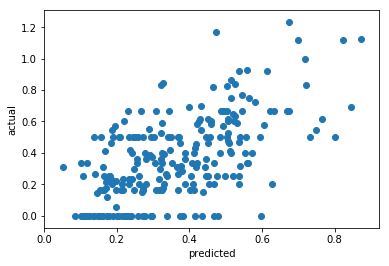

In [479]:
plt.figure()
plt.scatter(y_pred,Y.values)
plt.ylabel('actual')
plt.xlabel('predicted')

In [480]:
r2_score(Y.values,y_pred)

0.37919928919729362

In [482]:
player_df

,LastName,FirstName,JerseyNumber,Height,Weight,BirthDate,Age,BirthCity,BirthCountry,IsRookie,Goals,Assists,Points,HatTricks,PlusMinus,Shots,ShotPercentage,Penalties,PenaltyMinutes,PowerplayGoals,PowerplayAssists,PowerplayPoints,ShorthandedGoals,ShorthandedAssists,ShorthandedPoints,GameWinningGoals,GameTyingGoals,Hits,Faceoffs,FaceoffWins,FaceoffLosses,FaceoffPercent,GamesPlayed,team,PlayoffPoints,PlayoffGames,PlayoffPointsPG,PointsPG,ShotsPG,AssistsPG,GoalsPG,TeamPts,Position_C,Position_D,Position_LW,Position_RW
4265,Kane,Patrick,88,"5'11""",177,1988-11-19,29,"Buffalo, NY",USA,false,34,55,89,0,11,292,11.6,16,32,7,16,23,0,0,0,5,0,28,51,7,44,13.7,82,CHI,2,4.0,0.500000,1.085366,3.560976,0.670732,0.414634,109,0,0,0,1
5811,Panarin,Artemi,72,"5'11""",168,1991-10-30,26,Korkino,Russia,false,31,43,74,0,18,211,14.7,10,23,9,8,17,0,0,0,5,0,23,10,2,8,20.0,82,CHI,1,4.0,0.250000,0.902439,2.573171,0.524390,0.378049,109,0,0,1,0
3715,Keith,Duncan,2,"6'1""",192,1983-07-16,34,"Winnipeg, MB",Canada,false,6,47,53,0,22,183,3.3,8,16,2,13,15,0,0,0,2,0,24,0,0,0,0.0,80,CHI,1,4.0,0.250000,0.662500,2.287500,0.587500,0.075000,109,0,1,0,0
219,Hossa,Marian,81,"6'1""",207,1979-01-12,39,Stará Lubovna,Slovakia,false,26,19,45,0,7,167,15.6,4,8,5,6,11,1,0,1,7,0,32,14,5,9,35.7,73,CHI,0,4.0,0.000000,0.616438,2.287671,0.260274,0.356164,109,0,0,0,1
4620,Anisimov,Artem,15,"6'4""",198,1988-05-24,29,Yaroslavl,Russia,false,22,23,45,0,9,105,21.0,15,30,4,4,8,0,0,0,7,0,18,922,416,506,45.1,64,CHI,0,4.0,0.000000,0.703125,1.640625,0.359375,0.343750,109,1,0,0,0
5167,Panik,Richard,14,"6'1""",208,1991-02-07,27,Martin,Slovakia,false,22,22,44,0,14,155,14.2,21,58,4,5,9,0,0,0,5,0,147,7,2,5,28.6,82,CHI,1,4.0,0.250000,0.536585,1.890244,0.268293,0.268293,109,0,0,0,1
3634,Seabrook,Brent,7,"6'3""",220,1985-04-20,32,"Richmond, BC",Canada,false,3,36,39,0,5,131,2.3,13,26,2,12,14,0,0,0,0,0,111,1,0,1,0.0,79,CHI,0,4.0,0.000000,0.493671,1.658228,0.455696,0.037975,109,0,1,0,0
5522,Hartman,Ryan,38,"6'0""",181,1994-09-19,23,"Hilton Head Isl., SC",USA,false,19,12,31,0,13,170,11.2,24,70,1,0,1,0,0,0,4,0,121,62,25,37,40.3,76,CHI,0,4.0,0.000000,0.407895,2.236842,0.157895,0.250000,109,0,0,0,1
10071,Schmaltz,Nick,8,"6'0""",177,1996-02-23,22,"Madison, WI",USA,true,6,22,28,0,10,66,9.1,4,8,0,2,2,0,0,0,0,0,20,272,84,188,30.9,61,CHI,0,4.0,0.000000,0.459016,1.081967,0.360656,0.098361,109,1,0,0,0
568,Campbell,Brian,51,"5'10""",192,1979-05-23,38,"Strathroy, ON",Canada,false,5,12,17,0,12,74,6.8,13,26,2,3,5,0,0,0,1,0,43,0,0,0,0.0,80,CHI,0,4.0,0.000000,0.212500,0.925000,0.150000,0.062500,109,0,1,0,0


In [483]:
player_df.loc[:,'PredictedPPG'] = y_pred

In [485]:
player_df.to_pickle('individual.pickle')